In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from concurrent import futures
from functools import partial
from model import get_model, pH
from modelbase.ode import Simulator
from tqdm import tqdm
from typing import Iterable

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/elouen/miniforge3/envs/Ebenhoeh2011/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/elouen/miniforge3/envs/Ebenhoeh2011/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/elouen/miniforge3/envs/Ebenhoeh2011/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


In [2]:
m = get_model()

y0 = {
    "A1": m.parameters["D"] / 2,
    "A2": m.parameters["D"] / 2,
    "P": 0,
    "H": 6.34e-5,
    "N": 0,
    "T": 0,
}

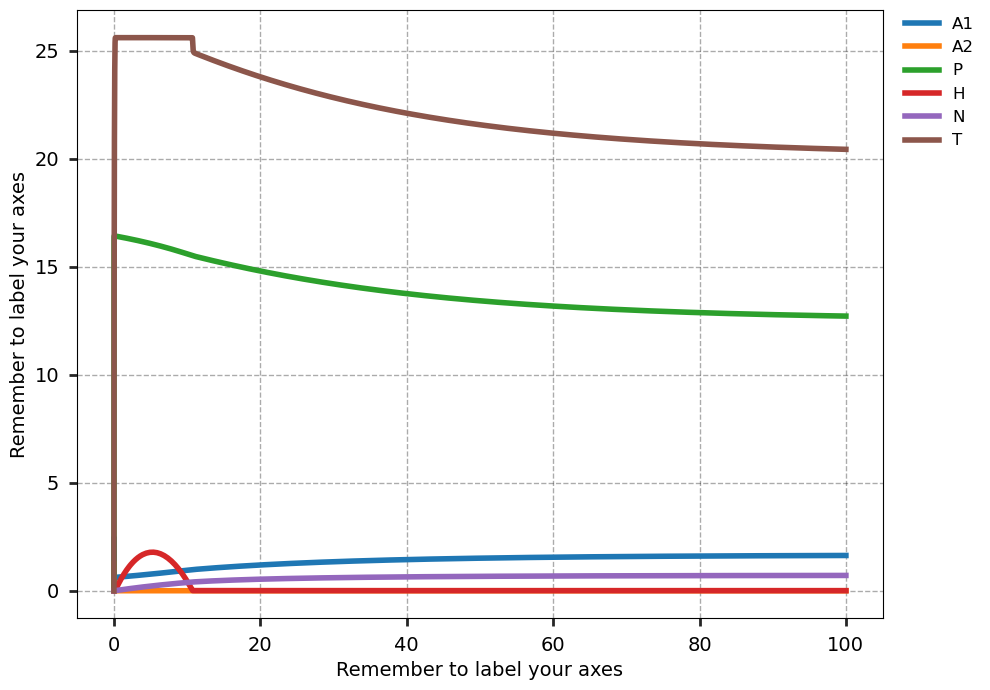

In [3]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("PFD", 1000)
s.simulate(100, atol=1e-12)
_ = s.plot()

In [4]:
def simulate_to_time_at_pfd(pfd: float, t: float) -> dict[str, float]:
    s = Simulator(get_model())
    s.update_parameter("PFD", pfd)
    s.initialise(y0)
    s.simulate(t, atol=1e-12, rtol=1e-12)
    assert (res := s.get_results_df()) is not None
    return res.iloc[-1].to_dict()


def scan_at_time(t: float, pfds: Iterable[float]) -> pd.DataFrame:
    import sys

    fn = partial(simulate_to_time_at_pfd, t=t)

    if sys.platform in ["win32", "cygwin"]:
        return pd.DataFrame(tqdm(map(fn, pfds)), index=pfds)  # type: ignore
    else:
        with futures.ProcessPoolExecutor() as ex:
            return pd.DataFrame(tqdm(ex.map(fn, pfds)), index=pfds)  # type: ignore


scan = scan_at_time(4000, np.linspace(1e-4, 2000, 100))

100it [00:04, 20.50it/s]


## Figure 4

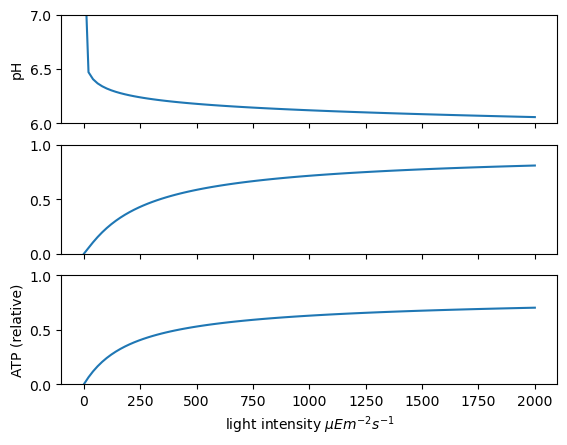

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

pH(scan["H"]).plot(ax=ax1, ylabel="pH")  # type: ignore
scan["N"].plot(ax=ax2, label="quenching, N")
(scan["T"] / get_model().parameters["A"]).plot(ax=ax3, ylabel="ATP (relative)")

ax1.set_ylim(6, 7)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_xlabel(r"light intensity $\mu Em^{-2}s^{-1}$")
plt.show()

## Figure 5

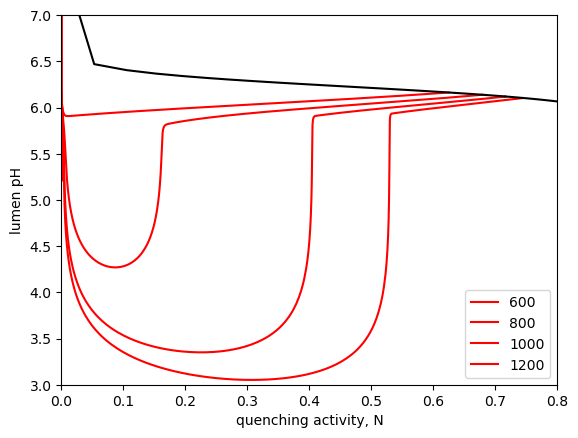

In [6]:
fig, ax = plt.subplots()

for j in [600, 800, 1000, 1200]:
    m.update_parameter("PFD", j)
    s = Simulator(get_model())
    s.update_parameter("PFD", j)
    s.initialise(y0)
    s.simulate(1000, atol=1e-12, rtol=1e-12)
    res = s.get_results_df()

    plt.plot(res["N"], pH(res["H"]), label=str(j), c="r")


ax.plot(
    scan["N"],
    pH(scan["H"]),  # type: ignore
    c="k",
)
ax.legend()
ax.set_xlabel("quenching activity, N")
ax.set_ylabel("lumen pH")
ax.set_xlim(0, 0.8)
ax.set_ylim(3, 7)
plt.show()